# **Brain Abnormality Classification**



Full name: Danial Ahangarani

Student Number: 400211546

In this exercise we are going to train a CNN-based model for a multi-class classification task, brain abnormality classification. The dataset we are going to use is a small imbalanced one that contains MRIs of both normal and abnormal brains.
We will learn how to use and refine models that have been already trained on some other rich datasets to deal with situations in which we don't have access to good datasets or powerful hardware.
This exercise has been broken into some smaller sections and each section has its score. What you are supposed to do is shown in `"======== TODO ========"` format. Any part which is showed by `...` should be completed. with There may be some **Questions** in the notes below. It is not necessary to answer these questions, but they will help you to do the next sections.

# Imports

First of all we need to import required libraries.

In [1]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import shutil
import os
import random
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# 1) Data Preparation:

## 1.1) Download Dataset

The following pieces of code will download dataset to your colab storage and remove corrupted or useless files.

In [2]:
!wget --content-disposition https://figshare.com/ndownloader/files/28399209
!mkdir dataset
!tar xvf NINS_Dataset.tar --directory dataset/

Streaming output truncated to the last 5000 lines.
./Brain Infection with abscess/58211497.jpg
./Brain Infection with abscess/58211513.jpg
./Brain Infection with abscess/58211529.jpg
./Brain Infection with abscess/58211545.jpg
./Brain Infection with abscess/58211561.jpg
./Brain Infection with abscess/58211577.jpg
./Brain Infection with abscess/58211593.jpg
./Brain Infection with abscess/58211609.jpg
./Brain Infection with abscess/97887252.jpg
./Brain Infection with abscess/97887268.jpg
./Brain Infection with abscess/97887284.jpg
./Brain Infection with abscess/97887300.jpg
./Brain Infection with abscess/97887316.jpg
./Brain Infection with abscess/97887332.jpg
./Brain Infection with abscess/97887348.jpg
./Brain Infection with abscess/97887364.jpg
./Brain Infection with abscess/97887380.jpg
./Brain Infection with abscess/97887396.jpg
./Brain Infection with abscess/97887412.jpg
./Brain Infection with abscess/97887428.jpg
./Brain Infection with abscess/97887444.jpg
./Brain Infection with ab

In [3]:
# Set the directory containing the images
data_dir = 'dataset/'

classes = os.listdir(data_dir)
shutil.rmtree(os.path.join(data_dir, 'models'))
classes = os.listdir(data_dir)

for c in classes:
    images = os.listdir(os.path.join(data_dir, c))
    for image in images:
      if image[-4:] != '.jpg':
        corrupted_img = os.path.join(data_dir, c, image)
        try:
          os.remove(corrupted_img)
        except:
          shutil.rmtree(corrupted_img)

## 1.2) Splitting Dataset: 5

The data should be spilitted into three groups: train, validation, and test. The groups' size are your choice and they should be reasonable, but it is recommended to use 0.8, 0.1, and 0.1 for train, validation, and test, respectively.

In [4]:
import os

# Set up directories and data splits
root_dir = 'dataset'
classes = os.listdir(root_dir)

############## To Do ##############
train_split = 0.8
val_split = 0.1
test_split = 0.1
###################################

# Create a dictionary with images and labels
data_dict = {}
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    data_dict[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

############## To Do ##############
# Create train, validation and test splits
# Also print the number of samples in each class
train_images = []
val_images = []
test_images = []
sizes = []

for cls_name, images in data_dict.items():
    num_samples = len(images)
    train_index = int(train_split * num_samples)
    val_index = int((train_split + val_split) * num_samples)

    train_images.extend(images[:train_index])
    val_images.extend(images[train_index:val_index])
    test_images.extend(images[val_index:])
    sizes.append(len(images[:train_index]))

    print(f"{cls_name}: {num_samples} samples, Train: {len(images[:train_index])}, Validation: {len(images[train_index:val_index])}, Test: {len(images[val_index:])}")
###################################


Encephalomalacia with gliotic change: 76 samples, Train: 60, Validation: 8, Test: 8
cerebral venous sinus thrombosis: 76 samples, Train: 60, Validation: 8, Test: 8
Small Vessel Diease Demyelination: 38 samples, Train: 30, Validation: 4, Test: 4
Microvascular ischemic change: 72 samples, Train: 57, Validation: 7, Test: 8
meningioma: 76 samples, Train: 60, Validation: 8, Test: 8
NMOSD  ADEM: 36 samples, Train: 28, Validation: 4, Test: 4
Postoperative encephalomalacia: 38 samples, Train: 30, Validation: 4, Test: 4
Brain Atrophy: 264 samples, Train: 211, Validation: 26, Test: 27
Obstructive Hydrocephalus: 76 samples, Train: 60, Validation: 8, Test: 8
Cerebral Hemorrhage: 36 samples, Train: 28, Validation: 4, Test: 4
Brain Tumor (Ependymoma): 36 samples, Train: 28, Validation: 4, Test: 4
Hemorrhagic collection: 38 samples, Train: 30, Validation: 4, Test: 4
Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis): 74 samples, Train: 59, Validation: 7, Test: 8
Normal: 1749 s

**Question:** How many classes are there in your dataset?

**Question:** Did you notice the imbalance between classes?

We put samples of each group in a seperate folder.

In [5]:
!mkdir train val test

n_img = 0
for image in train_images:
  n_img += 1
  os.makedirs(os.path.join('train', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('train', *image.split('/')[1:]))

for image in val_images:
  os.makedirs(os.path.join('val', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('val', *image.split('/')[1:]))

for image in test_images:
  os.makedirs(os.path.join('test', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('test', *image.split('/')[1:]))

## 1.3) Calculate Weights of Calsses: 5

As you saw there exists an imbalance between classes. The dataset contains a class with more than a thousand samples and classes with fewer than 50 samples.

Here we want to calculate coefficients (weights) that can compensate this gap. So you are supposed to calculate these coefficients for each class such that if you multiply a class size by its corresponding coefficient the result will be equal for all the other classes. The minimum value of a coefficient should be 1.

In [6]:
# Assuming that `classes` is a list of string class names with corresponding sizes in another list `sizes`
class_sizes = dict(zip(classes, sizes))
max_size = max(sizes)

class_weights = {}

for c, s in class_sizes.items():
  # Calculate the weight for this class
  weight = max_size / s
  if weight < 1:
    weight = 1
  class_weights[c] = weight

  # Print the size and weight of this class
  print(c)
  print('Size of Class'+ ': ' + str(s))
  print('Weight of Class ' + ': ' + str(weight))
  print()

# Convert the dictionary of weights to a PyTorch tensor
wgts = torch.Tensor(list(class_weights.values()))


Encephalomalacia with gliotic change
Size of Class: 60
Weight of Class : 23.316666666666666

cerebral venous sinus thrombosis
Size of Class: 60
Weight of Class : 23.316666666666666

Small Vessel Diease Demyelination
Size of Class: 30
Weight of Class : 46.63333333333333

Microvascular ischemic change
Size of Class: 57
Weight of Class : 24.54385964912281

meningioma
Size of Class: 60
Weight of Class : 23.316666666666666

NMOSD  ADEM
Size of Class: 28
Weight of Class : 49.964285714285715

Postoperative encephalomalacia
Size of Class: 30
Weight of Class : 46.63333333333333

Brain Atrophy
Size of Class: 211
Weight of Class : 6.630331753554502

Obstructive Hydrocephalus
Size of Class: 60
Weight of Class : 23.316666666666666

Cerebral Hemorrhage
Size of Class: 28
Weight of Class : 49.964285714285715

Brain Tumor (Ependymoma)
Size of Class: 28
Weight of Class : 49.964285714285715

Hemorrhagic collection
Size of Class: 30
Weight of Class : 46.63333333333333

Brain Tumor (Hemangioblastoma  Pleom

## 1.4) Create DataLoaders: 5

We read and put the data of each group in its corresponding list.

In [7]:
train_images = []
train_aug_images = []
val_images = []
test_images = []

for c in classes:
    class_dir = os.path.join('train', c)
    train_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('val', c)
    val_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('test', c)
    test_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

Define required transforms and create Dataloaders.

**Question:** What is the approperiate input size of models like ResNet, VGG, etc.? Becarefull about the size of your images as well.

**Notice:** Select a suitable batch size.

**Notice:** Becarefull about the range of input values. They should be in [0, 1).

In [8]:
batch_size = 64
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_list, classes=None, transform=None):
        self.image_list = image_list
        self.transform = transform
        self.label_encoder = {c: i for (i, c) in enumerate(classes)}

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = Image.open(self.image_list[index])

        if self.transform is not None:
            image = self.transform(image)

        label = self.image_list[index].split('/')[-2]
        label = self.label_encoder[label]

        return image, label


# Define the transformations to be applied on the train and validation sets
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Create datasets using defined CustomDataset class
train_dataset = CustomDataset(image_list=train_images, classes=classes, transform=transforms)
val_dataset = CustomDataset(image_list=val_images, classes=classes, transform=transforms)
test_dataset = CustomDataset(image_list=test_images, classes=classes, transform=transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
data_loaders = {'train': train_loader, 'val': val_loader}
num_cls = len(classes) # Number of classes

## 1.2) Data Visualization

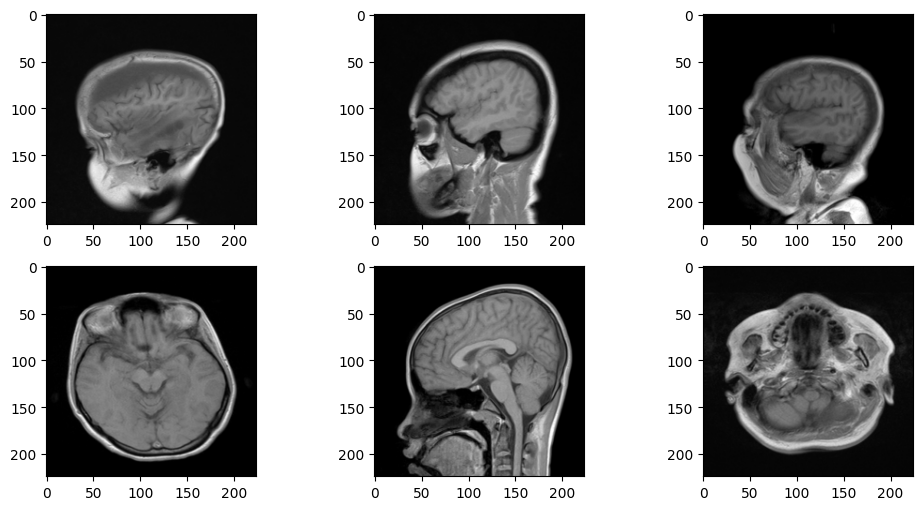

In [10]:
fig, axis = plt.subplots(2, 3, figsize=(12, 6))
for i, batch in enumerate(train_loader):
  axis[0, 0].imshow(np.array(batch[0][0]).transpose(1, 2, 0))
  axis[0, 1].imshow(np.array(batch[0][1]).transpose(1, 2, 0))
  axis[0, 2].imshow(np.array(batch[0][2]).transpose(1, 2, 0))
  axis[1, 0].imshow(np.array(batch[0][-3]).transpose(1, 2, 0),)
  axis[1, 1].imshow(np.array(batch[0][-2]).transpose(1, 2, 0),)
  axis[1, 2].imshow(np.array(batch[0][-1]).transpose(1, 2, 0),)
  break

# 2) Model Initialization and Structure Modification


## 2.1) ResNet50: 10

Load ResNet50 model with its pretrained weights. (Suggestion: IMAGENET1K_V2)

In [11]:
############## To Do ##############
resnet_model = models.resnet50(pretrained=True)
###################################

# Print the structure of the loaded model
print(resnet_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 297MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [12]:
############## To Do ##############
# Freeze all parameters in the convolutional layers
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the fully connected layer with a new one with num_cls
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = torch.nn.Linear(num_ftrs, num_cls)
###################################

# Print the structure of the modified model and notice the difference
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

## 2.2) VGG16: 10

Load VGG16 model with its pretrained parameters. (Suggestion: IMAGENET1K_V1)

In [14]:
############## To Do ##############
vgg_model = models.vgg16(pretrained=True)
###################################

# Print the structure of the loaded model
print(vgg_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 301MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [15]:
############## To Do ##############
# Freeze all layers in the model
for param in vgg_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to have 37 output features
num_features = vgg_model.classifier[-1].in_features
vgg_model.classifier[-1] = nn.Linear(num_features, num_cls)
###################################

# Print the structure of the modified model and notice the difference
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

# 3) Train Function: 15

Define your loss function for multi class classification. Don't forget to add class weights to it.

In [21]:
wgts = wgts.to(device)

############## To Do ##############
criterion = nn.CrossEntropyLoss(weight=wgts)
###################################

Here you should define your main train function.

**Note1:** Since you are going to change the data during the training procedure, your train function have to get dataloaders as input.

**Note2:** Also you don't know how many epochs you should train.
  So save the best weights according to validation loss at the end of each epoch,
  and after the end of training, load the best model.

**Note3:** Save loss and accuracy of train and validation in each epoch to plot them later.

**Note4:** The following code is an template that can help you, but any other functions that you define with the desired properties is acceptable.


In [22]:
############## To Do ##############
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()

    acc_hist = { 'train': [], 'val': [] }
    loss_hist = { 'train': [], 'val': [] }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()


            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # zero the parameter gradients

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate outputs, predictions, and losses
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            if phase == 'val' and not(scheduler is None):
                scheduler.step(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_hist[phase].append(epoch_acc)
            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights with the stored state dictionary
    model.load_state_dict(best_model_wts)

    return model, acc_hist, loss_hist
###################################

# 4) Feature Extraction


In this section with just update parameters of the recently modified layer(s).

### 4.1) ResNet50

### 4.1.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [23]:
############## To Do ##############
# Your code ...
# I froze the parameters except for the new layer after loading.
###################################

### 4.1.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [24]:
############## To Do ##############
new_layer_params = list(resnet_model.fc.parameters())
resnet_optimizer = optim.Adam(new_layer_params, lr=0.001)
###################################

lr_scheduler = None

In [25]:
############## To Do ##############
resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, scheduler=None, num_epochs=10)
###################################

Epoch 0/9
----------
train Loss: 3.6922 Acc: 0.0390
val Loss: 3.4975 Acc: 0.0485

Epoch 1/9
----------
train Loss: 2.8931 Acc: 0.1246
val Loss: 2.8665 Acc: 0.1343

Epoch 2/9
----------
train Loss: 2.4440 Acc: 0.1854
val Loss: 2.7720 Acc: 0.1474

Epoch 3/9
----------
train Loss: 2.1176 Acc: 0.2432
val Loss: 2.5341 Acc: 0.1810

Epoch 4/9
----------
train Loss: 1.8873 Acc: 0.2612
val Loss: 2.2571 Acc: 0.2463

Epoch 5/9
----------
train Loss: 1.6594 Acc: 0.3064
val Loss: 2.2798 Acc: 0.2127

Epoch 6/9
----------
train Loss: 1.4993 Acc: 0.3245
val Loss: 2.1330 Acc: 0.2705

Epoch 7/9
----------
train Loss: 1.3551 Acc: 0.3532
val Loss: 2.1553 Acc: 0.2575

Epoch 8/9
----------
train Loss: 1.2598 Acc: 0.3722
val Loss: 2.1613 Acc: 0.2612

Epoch 9/9
----------
train Loss: 1.1666 Acc: 0.3848
val Loss: 2.1575 Acc: 0.2388

Training complete in 5m 45s
Best val Acc: 0.270522


### 4.2) VGG16

### 4.2.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [26]:
############## To Do ##############
# Your code ...
# I froze the parameters except for the new layer after loading.
###################################

### 4.2.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [27]:
############## To Do ##############
new_layer_params = list(vgg_model.classifier.parameters())[-2:]
vgg_optimizer = optim.Adam(new_layer_params, lr=0.001)
###################################

lr_scheduler = None

In [28]:
############## To Do ##############
vgg_fe, vgg_acc_fe, vgg_loss_fe = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, scheduler=None, num_epochs=10)
###################################

Epoch 0/9
----------
train Loss: 3.7396 Acc: 0.0390
val Loss: 3.3494 Acc: 0.0802

Epoch 1/9
----------
train Loss: 3.0457 Acc: 0.0837
val Loss: 3.2035 Acc: 0.0914

Epoch 2/9
----------
train Loss: 2.6896 Acc: 0.1143
val Loss: 2.9268 Acc: 0.1101

Epoch 3/9
----------
train Loss: 2.4674 Acc: 0.1417
val Loss: 2.7778 Acc: 0.1250

Epoch 4/9
----------
train Loss: 2.3635 Acc: 0.1528
val Loss: 2.6195 Acc: 0.1418

Epoch 5/9
----------
train Loss: 2.2026 Acc: 0.1704
val Loss: 2.5848 Acc: 0.1530

Epoch 6/9
----------
train Loss: 2.0887 Acc: 0.1818
val Loss: 2.6466 Acc: 0.1623

Epoch 7/9
----------
train Loss: 2.0162 Acc: 0.1985
val Loss: 2.3717 Acc: 0.1716

Epoch 8/9
----------
train Loss: 1.9720 Acc: 0.1966
val Loss: 2.3241 Acc: 0.1884

Epoch 9/9
----------
train Loss: 1.9082 Acc: 0.2127
val Loss: 2.4487 Acc: 0.1530

Training complete in 7m 10s
Best val Acc: 0.188433


# 5) Fine-Tuning


In this section the whole parameters of the model are going to be updated.

## 5.1) ResNet50

### 5.1.1) Unfreezing

Unfreeze all the parameters.

In [29]:
############## To Do ##############
for param in resnet_model.parameters():
    param.requires_grad_()
###################################

### 5.1.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [30]:
############## To Do ##############
resnet_optimizer = optim.SGD(resnet_model.parameters(), lr=0.001)

lr_scheduler = None

resnet_ft, resnet_acc_ft, resnet_loss_ft = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, scheduler=None, num_epochs=30)
###################################

Epoch 0/29
----------
train Loss: 1.3073 Acc: 0.3706
val Loss: 2.0390 Acc: 0.2761

Epoch 1/29
----------
train Loss: 0.9685 Acc: 0.4386
val Loss: 2.0112 Acc: 0.2780

Epoch 2/29
----------
train Loss: 0.7966 Acc: 0.4744
val Loss: 1.8614 Acc: 0.3414

Epoch 3/29
----------
train Loss: 0.6606 Acc: 0.5099
val Loss: 1.7598 Acc: 0.3750

Epoch 4/29
----------
train Loss: 0.5730 Acc: 0.5377
val Loss: 1.6292 Acc: 0.4142

Epoch 5/29
----------
train Loss: 0.5067 Acc: 0.5626
val Loss: 1.5697 Acc: 0.4422

Epoch 6/29
----------
train Loss: 0.4551 Acc: 0.5847
val Loss: 1.5721 Acc: 0.4328

Epoch 7/29
----------
train Loss: 0.4055 Acc: 0.6002
val Loss: 1.4910 Acc: 0.4701

Epoch 8/29
----------
train Loss: 0.3729 Acc: 0.6261
val Loss: 1.4600 Acc: 0.4701

Epoch 9/29
----------
train Loss: 0.3360 Acc: 0.6425
val Loss: 1.3571 Acc: 0.5280

Epoch 10/29
----------
train Loss: 0.3136 Acc: 0.6603
val Loss: 1.3562 Acc: 0.5168

Epoch 11/29
----------
train Loss: 0.2939 Acc: 0.6732
val Loss: 1.3540 Acc: 0.5131

Ep

## 5.2) VGG16

### 5.2.1) Unfreezing

Unfreeze all the parameters.

In [31]:
############## To Do ##############
for param in vgg_model.parameters():
    param.requires_grad_()
###################################

### 5.2.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [32]:
############## To Do ##############
vgg_optimizer = optim.SGD(vgg_model.parameters(), lr=0.001)

lr_schedular = None

vgg_ft, vgg_acc_ft, vgg_loss_ft = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, scheduler=None, num_epochs=30)
###################################

Epoch 0/29
----------
train Loss: 1.6257 Acc: 0.2589
val Loss: 2.1393 Acc: 0.2276

Epoch 1/29
----------
train Loss: 1.3272 Acc: 0.3062
val Loss: 1.9533 Acc: 0.2537

Epoch 2/29
----------
train Loss: 1.0803 Acc: 0.3366
val Loss: 1.8676 Acc: 0.2761

Epoch 3/29
----------
train Loss: 1.0204 Acc: 0.3592
val Loss: 1.7469 Acc: 0.3041

Epoch 4/29
----------
train Loss: 0.8626 Acc: 0.4003
val Loss: 1.7998 Acc: 0.3060

Epoch 5/29
----------
train Loss: 0.7457 Acc: 0.4134
val Loss: 1.7059 Acc: 0.3172

Epoch 6/29
----------
train Loss: 0.7342 Acc: 0.4212
val Loss: 1.6016 Acc: 0.3340

Epoch 7/29
----------
train Loss: 0.6481 Acc: 0.4457
val Loss: 1.7677 Acc: 0.3041

Epoch 8/29
----------
train Loss: 0.5702 Acc: 0.4718
val Loss: 1.5712 Acc: 0.3489

Epoch 9/29
----------
train Loss: 0.5153 Acc: 0.4928
val Loss: 1.4960 Acc: 0.3526

Epoch 10/29
----------
train Loss: 0.4875 Acc: 0.4966
val Loss: 1.5142 Acc: 0.3769

Epoch 11/29
----------
train Loss: 0.4323 Acc: 0.5175
val Loss: 1.4524 Acc: 0.3955

Ep

## 6) Plot Learning Curves: 5

Put the results of feature extraction and fine-tuning together and plot 2 figures for each of the models: accuracy and loss against epochs, i.e. 4 figures at all. Plot validation and train in one figure. Plot a vertical line that distinguish between feature extraction and fine-tuning epochs.

In [58]:
res_train_acc_fe = [resnet_acc_fe['train'][i].item() for i in range(len(resnet_acc_fe['train']))]
res_train_acc_ft = [resnet_acc_ft['train'][i].item() for i in range(len(resnet_acc_ft['train']))]
res_val_acc_fe = [resnet_acc_fe['val'][i].item() for i in range(len(resnet_acc_fe['val']))]
res_val_acc_ft = [resnet_acc_ft['val'][i].item() for i in range(len(resnet_acc_ft['val']))]
res_train_acc = res_train_acc_fe + res_train_acc_ft
res_val_acc = res_val_acc_fe + res_val_acc_ft

vgg_train_acc_fe = [vgg_acc_fe['train'][i].item() for i in range(len(vgg_acc_fe['train']))]
vgg_train_acc_ft = [vgg_acc_ft['train'][i].item() for i in range(len(vgg_acc_ft['train']))]
vgg_val_acc_fe = [vgg_acc_fe['val'][i].item() for i in range(len(vgg_acc_fe['val']))]
vgg_val_acc_ft = [vgg_acc_ft['val'][i].item() for i in range(len(vgg_acc_ft['val']))]
vgg_train_acc = vgg_train_acc_fe + vgg_train_acc_ft
vgg_val_acc = vgg_val_acc_fe + vgg_val_acc_ft


res_train_loss_fe = [resnet_loss_fe['train'][i] for i in range(len(resnet_loss_fe['train']))]
res_train_loss_ft = [resnet_loss_ft['train'][i] for i in range(len(resnet_loss_ft['train']))]
res_val_loss_fe = [resnet_loss_fe['val'][i] for i in range(len(resnet_loss_fe['val']))]
res_val_loss_ft = [resnet_loss_ft['val'][i] for i in range(len(resnet_loss_ft['val']))]
res_train_loss = res_train_loss_fe + res_train_loss_ft
res_val_loss = res_val_loss_fe + res_val_loss_ft


vgg_train_loss_fe = [vgg_loss_fe['train'][i] for i in range(len(vgg_loss_fe['train']))]
vgg_train_loss_ft = [vgg_loss_ft['train'][i] for i in range(len(vgg_loss_ft['train']))]
vgg_val_loss_fe = [vgg_loss_fe['val'][i] for i in range(len(vgg_loss_fe['val']))]
vgg_val_loss_ft = [vgg_loss_ft['val'][i] for i in range(len(vgg_loss_ft['val']))]
vgg_train_loss = vgg_train_loss_fe + vgg_train_loss_ft
vgg_val_loss = vgg_val_loss_fe + vgg_val_loss_ft

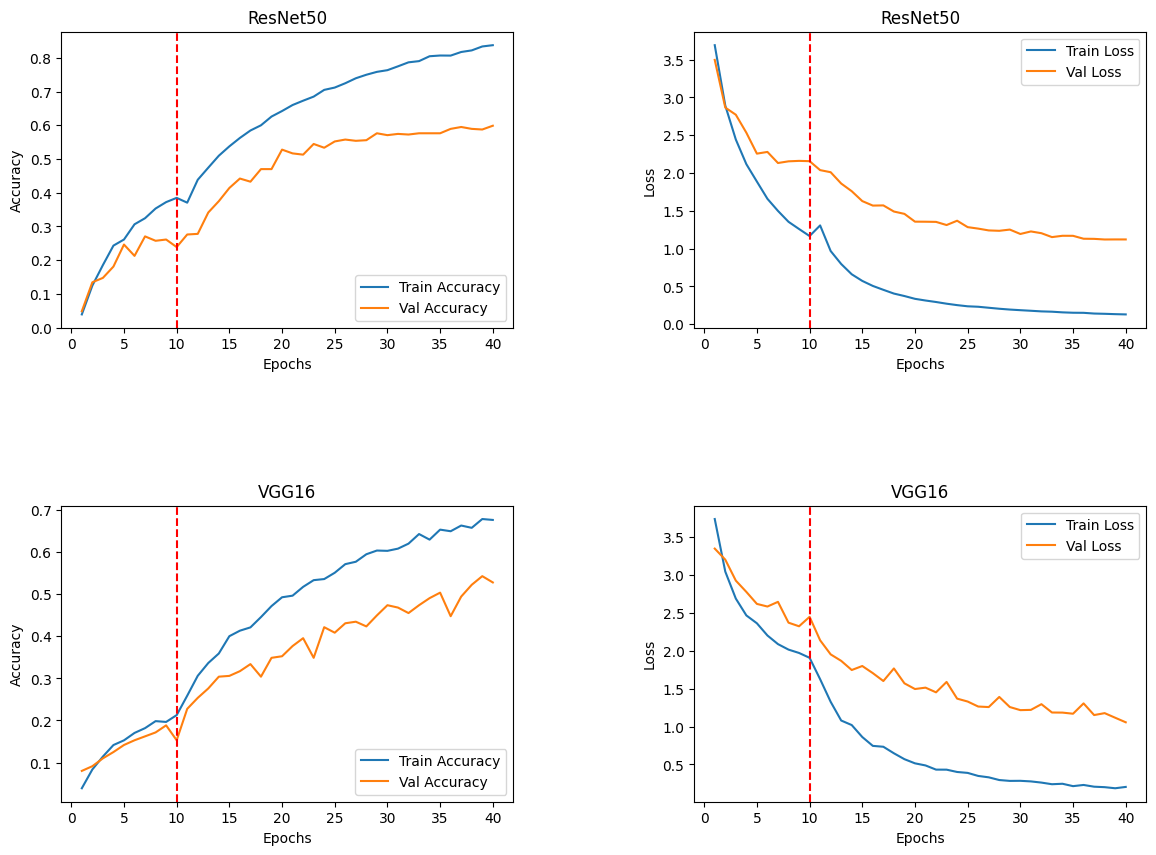

In [72]:
epochs = 40
# Set figure size
plt.figure(figsize=(14, 10))

# Plot 1: ResNet50 Accuracy
plt.subplot(2, 2, 1)
plt.plot(np.arange(1, epochs+1), res_train_acc, label='Train Accuracy')
plt.plot(np.arange(1, epochs+1), res_val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50')
plt.axvline(x=10, linestyle='--', color='red')
plt.legend()

# Plot 2: ResNet50 Loss
plt.subplot(2, 2, 2)
plt.plot(np.arange(1, epochs+1), res_train_loss, label='Train Loss')
plt.plot(np.arange(1, epochs+1), res_val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50')
plt.axvline(x=10, linestyle='--', color='red')
plt.legend()

# Plot 3: VGG16 Accuracy
plt.subplot(2, 2, 3)
plt.plot(np.arange(1, epochs+1), vgg_train_acc, label='Train Accuracy')
plt.plot(np.arange(1, epochs+1), vgg_val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16')
plt.axvline(x=10, linestyle='--', color='red')
plt.legend()

# Plot 4: VGG16 Loss
plt.subplot(2, 2, 4)
plt.plot(np.arange(1, epochs+1), vgg_train_loss, label='Train Loss')
plt.plot(np.arange(1, epochs+1), vgg_val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16')
plt.axvline(x=10, linestyle='--', color='red')
plt.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.show()


## 7) Confusion Matrix: 5

Plot confusion matrix for each of the models. It should be a `num_of_classes * num_of_classes` square.

In [111]:
model = resnet_ft

model.eval() # Set the model to evaluation mode

predictions = []
labels = []
with torch.no_grad():
    for images, label in val_loader:
        images = images.to(device)
        labels.extend(label)
        label = label.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())

labels = [int(tensor.numpy()) for tensor in labels]


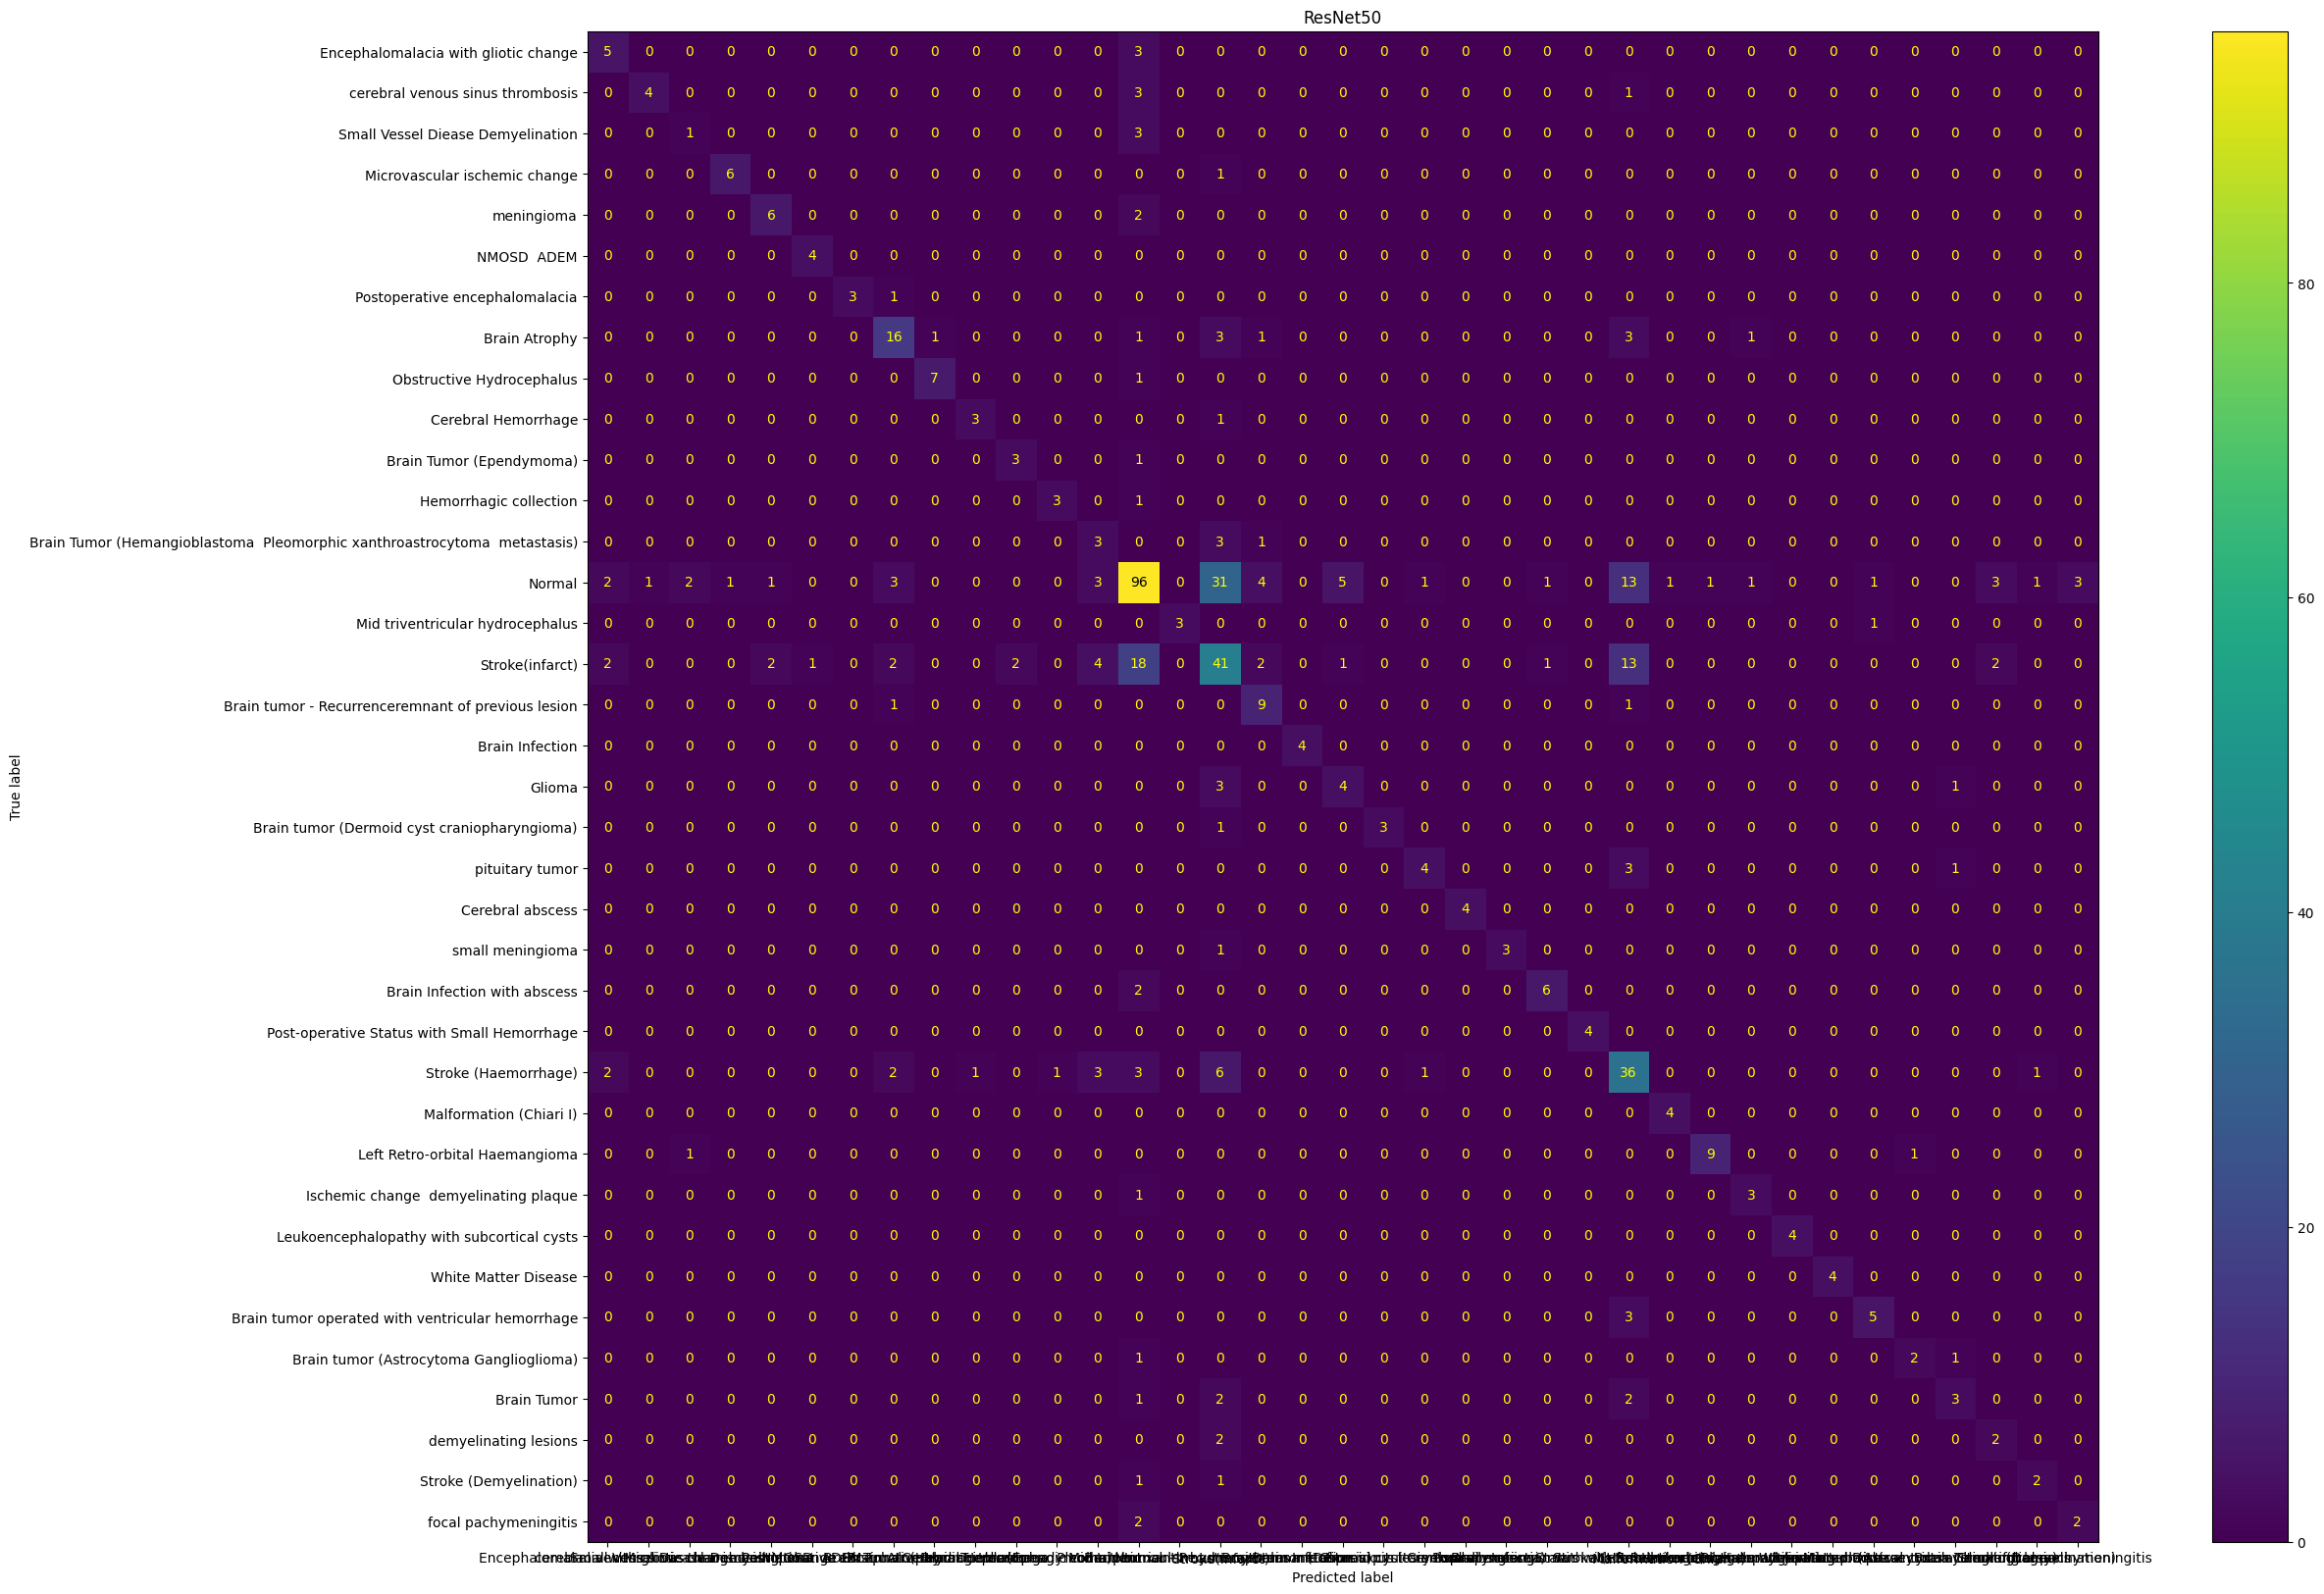

In [112]:
# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

# Set figure size
fig, ax = plt.subplots(figsize=(30, 20))

# Plot confusion matrix with color map
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
ax.figure.colorbar(im, ax=ax)

# Add title and axis labels
ax.set(title='ResNet50',
       xlabel='Predicted label',
       ylabel='True label')

# Add tick marks and labels for axes
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)

# Add values to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "yellow")

# Display plot
plt.show()


In [ ]:
model = vgg_ft

model.eval() # Set the model to evaluation mode

predictions = []
labels = []
with torch.no_grad():
    for images, label in val_loader:
        images = images.to(device)
        labels.extend(label)
        label = label.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())

labels = [int(tensor.numpy()) for tensor in labels]


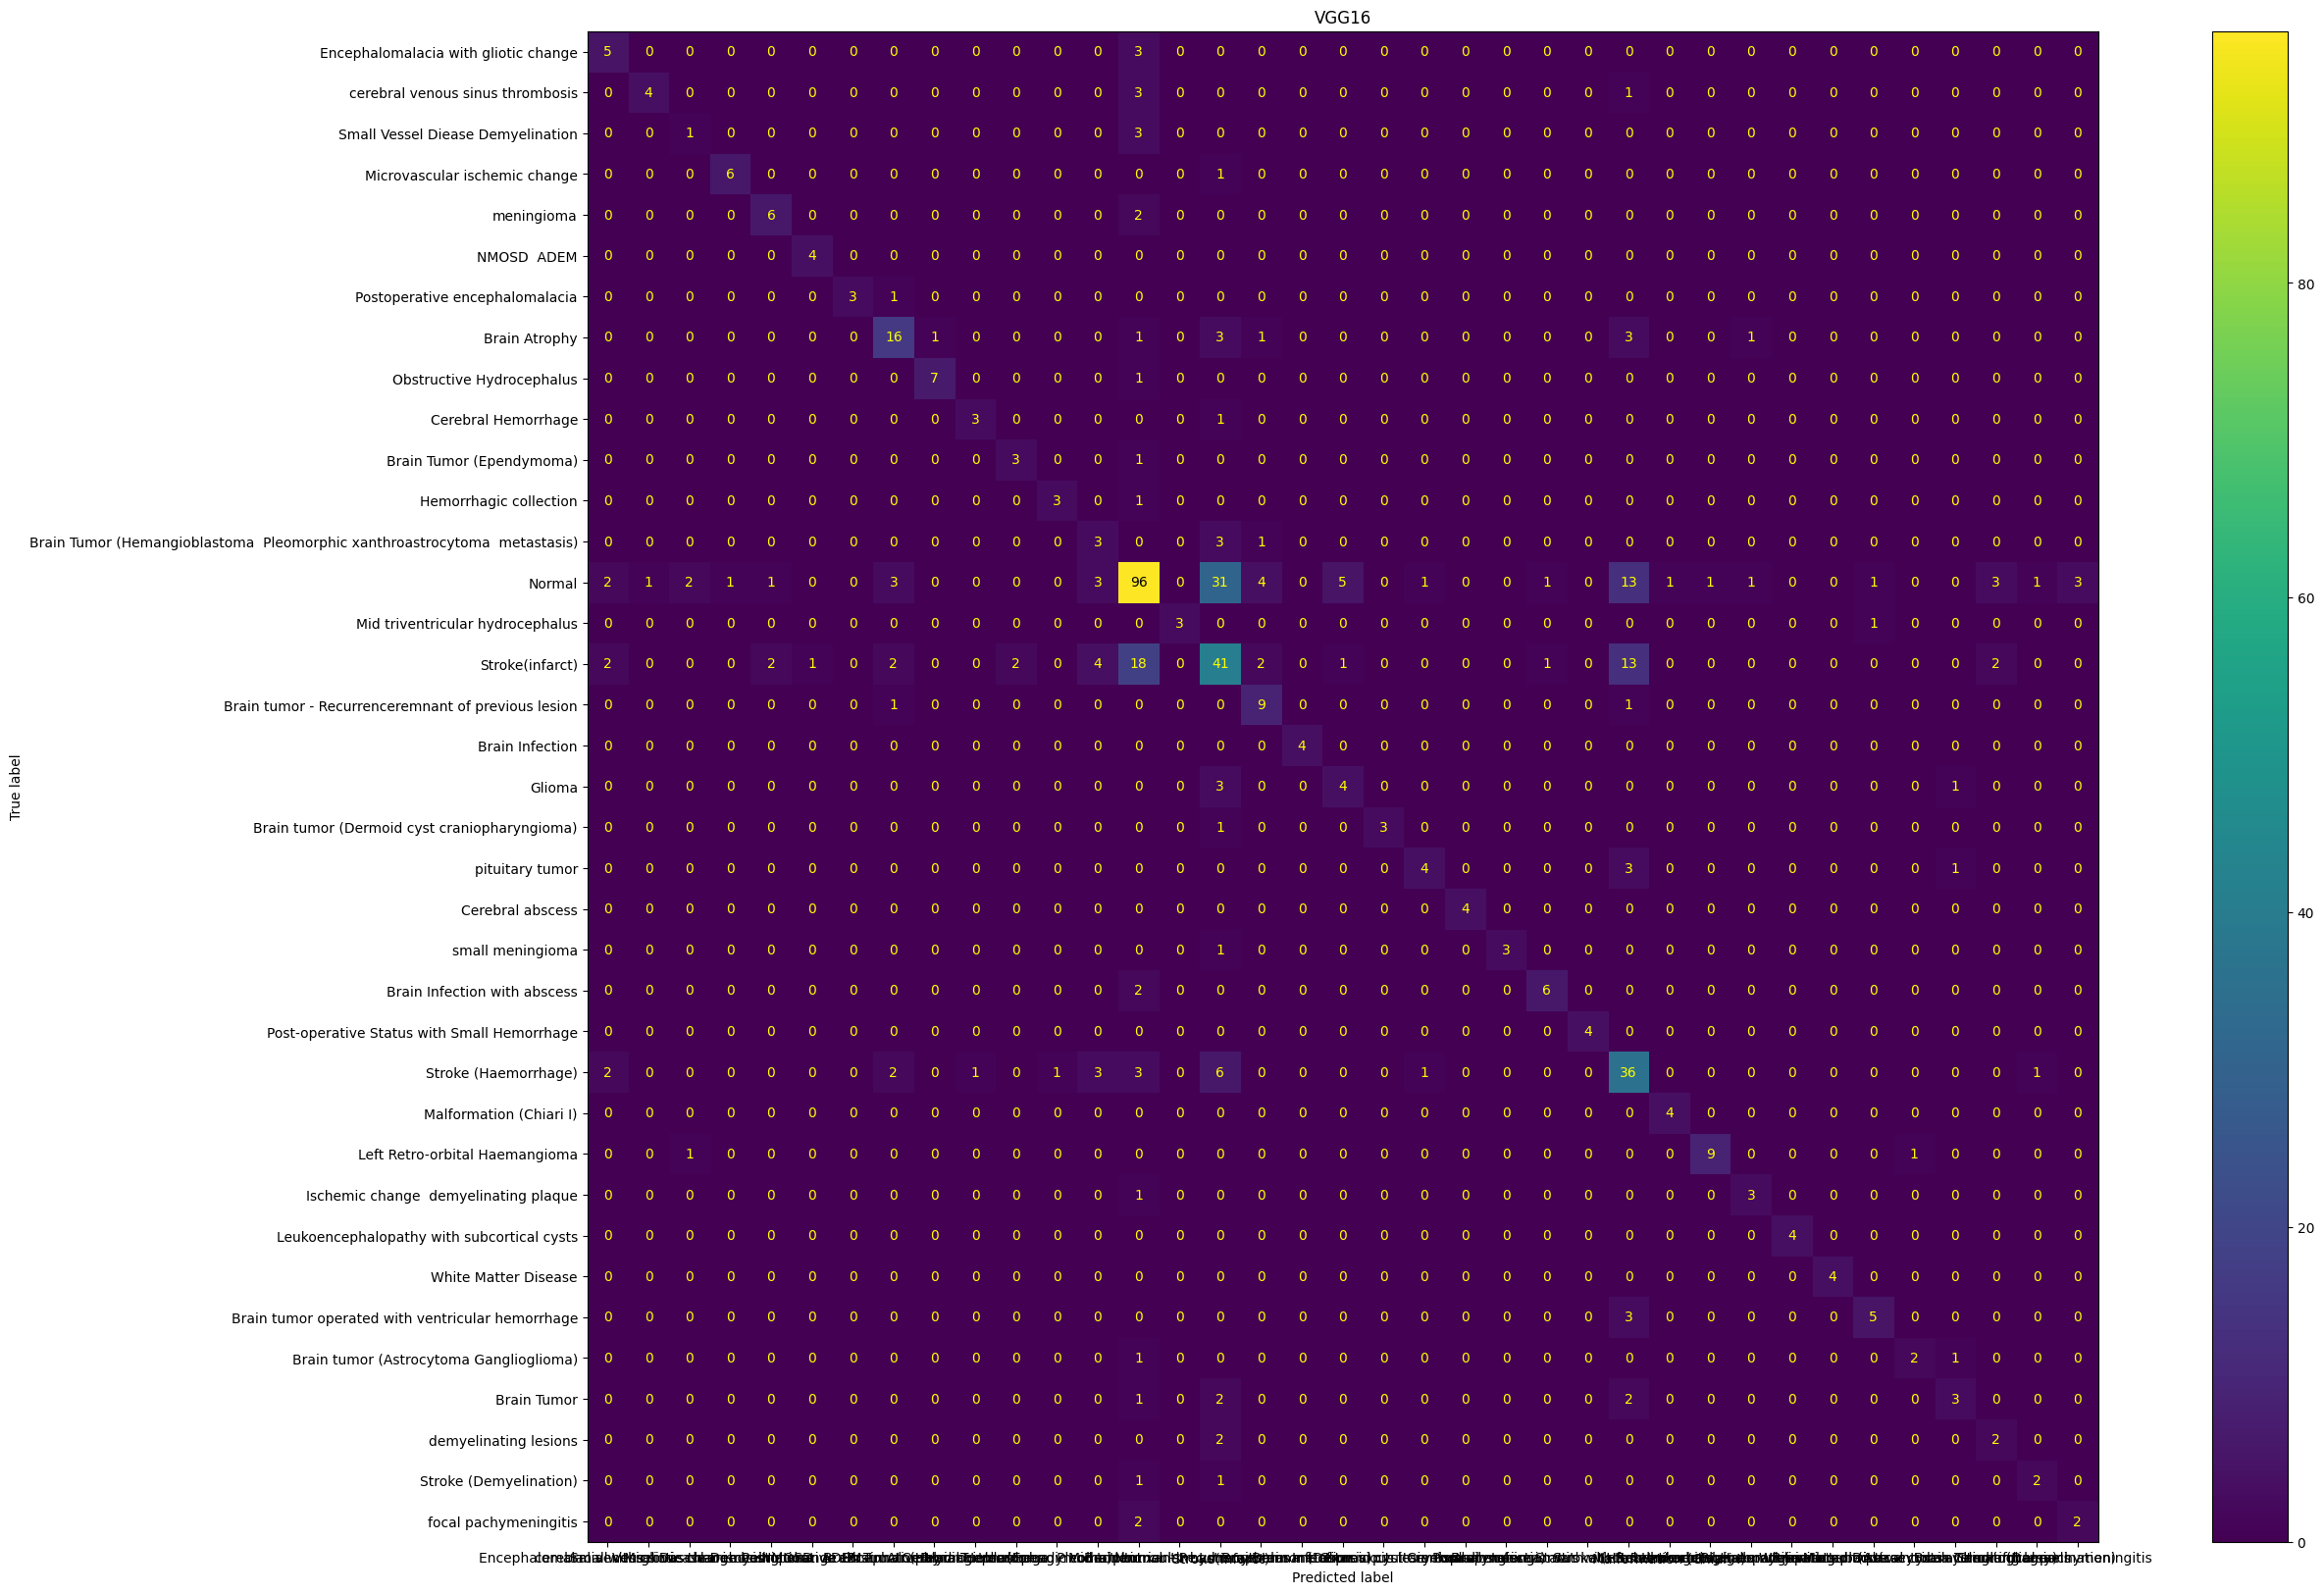

In [113]:
# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

# Set figure size
fig, ax = plt.subplots(figsize=(30, 20))

# Plot confusion matrix with color map
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
ax.figure.colorbar(im, ax=ax)

# Add title and axis labels
ax.set(title='VGG16',
       xlabel='Predicted label',
       ylabel='True label')

# Add tick marks and labels for axes
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)

# Add values to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "yellow")

# Display plot
plt.show()


# 9) Evaluate on Test Split: 10

Calculate the accuracy of each model on test data and also plot confusion matrix for both of them.

In [114]:
model = resnet_ft

model.eval() # Set the model to evaluation mode

predictions = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        labels.extend(label)
        label = label.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())

labels = [int(tensor.numpy()) for tensor in labels]

In [122]:
num_correct = 0
for i in range(len(labels)):
    if predictions[i] == labels[i]:
        num_correct += 1

accuracy = (num_correct / len(labels)) * 100
print(f'ResNet50 Accuracy: {accuracy}')

ResNet50 Accuracy: 63.837638376383765


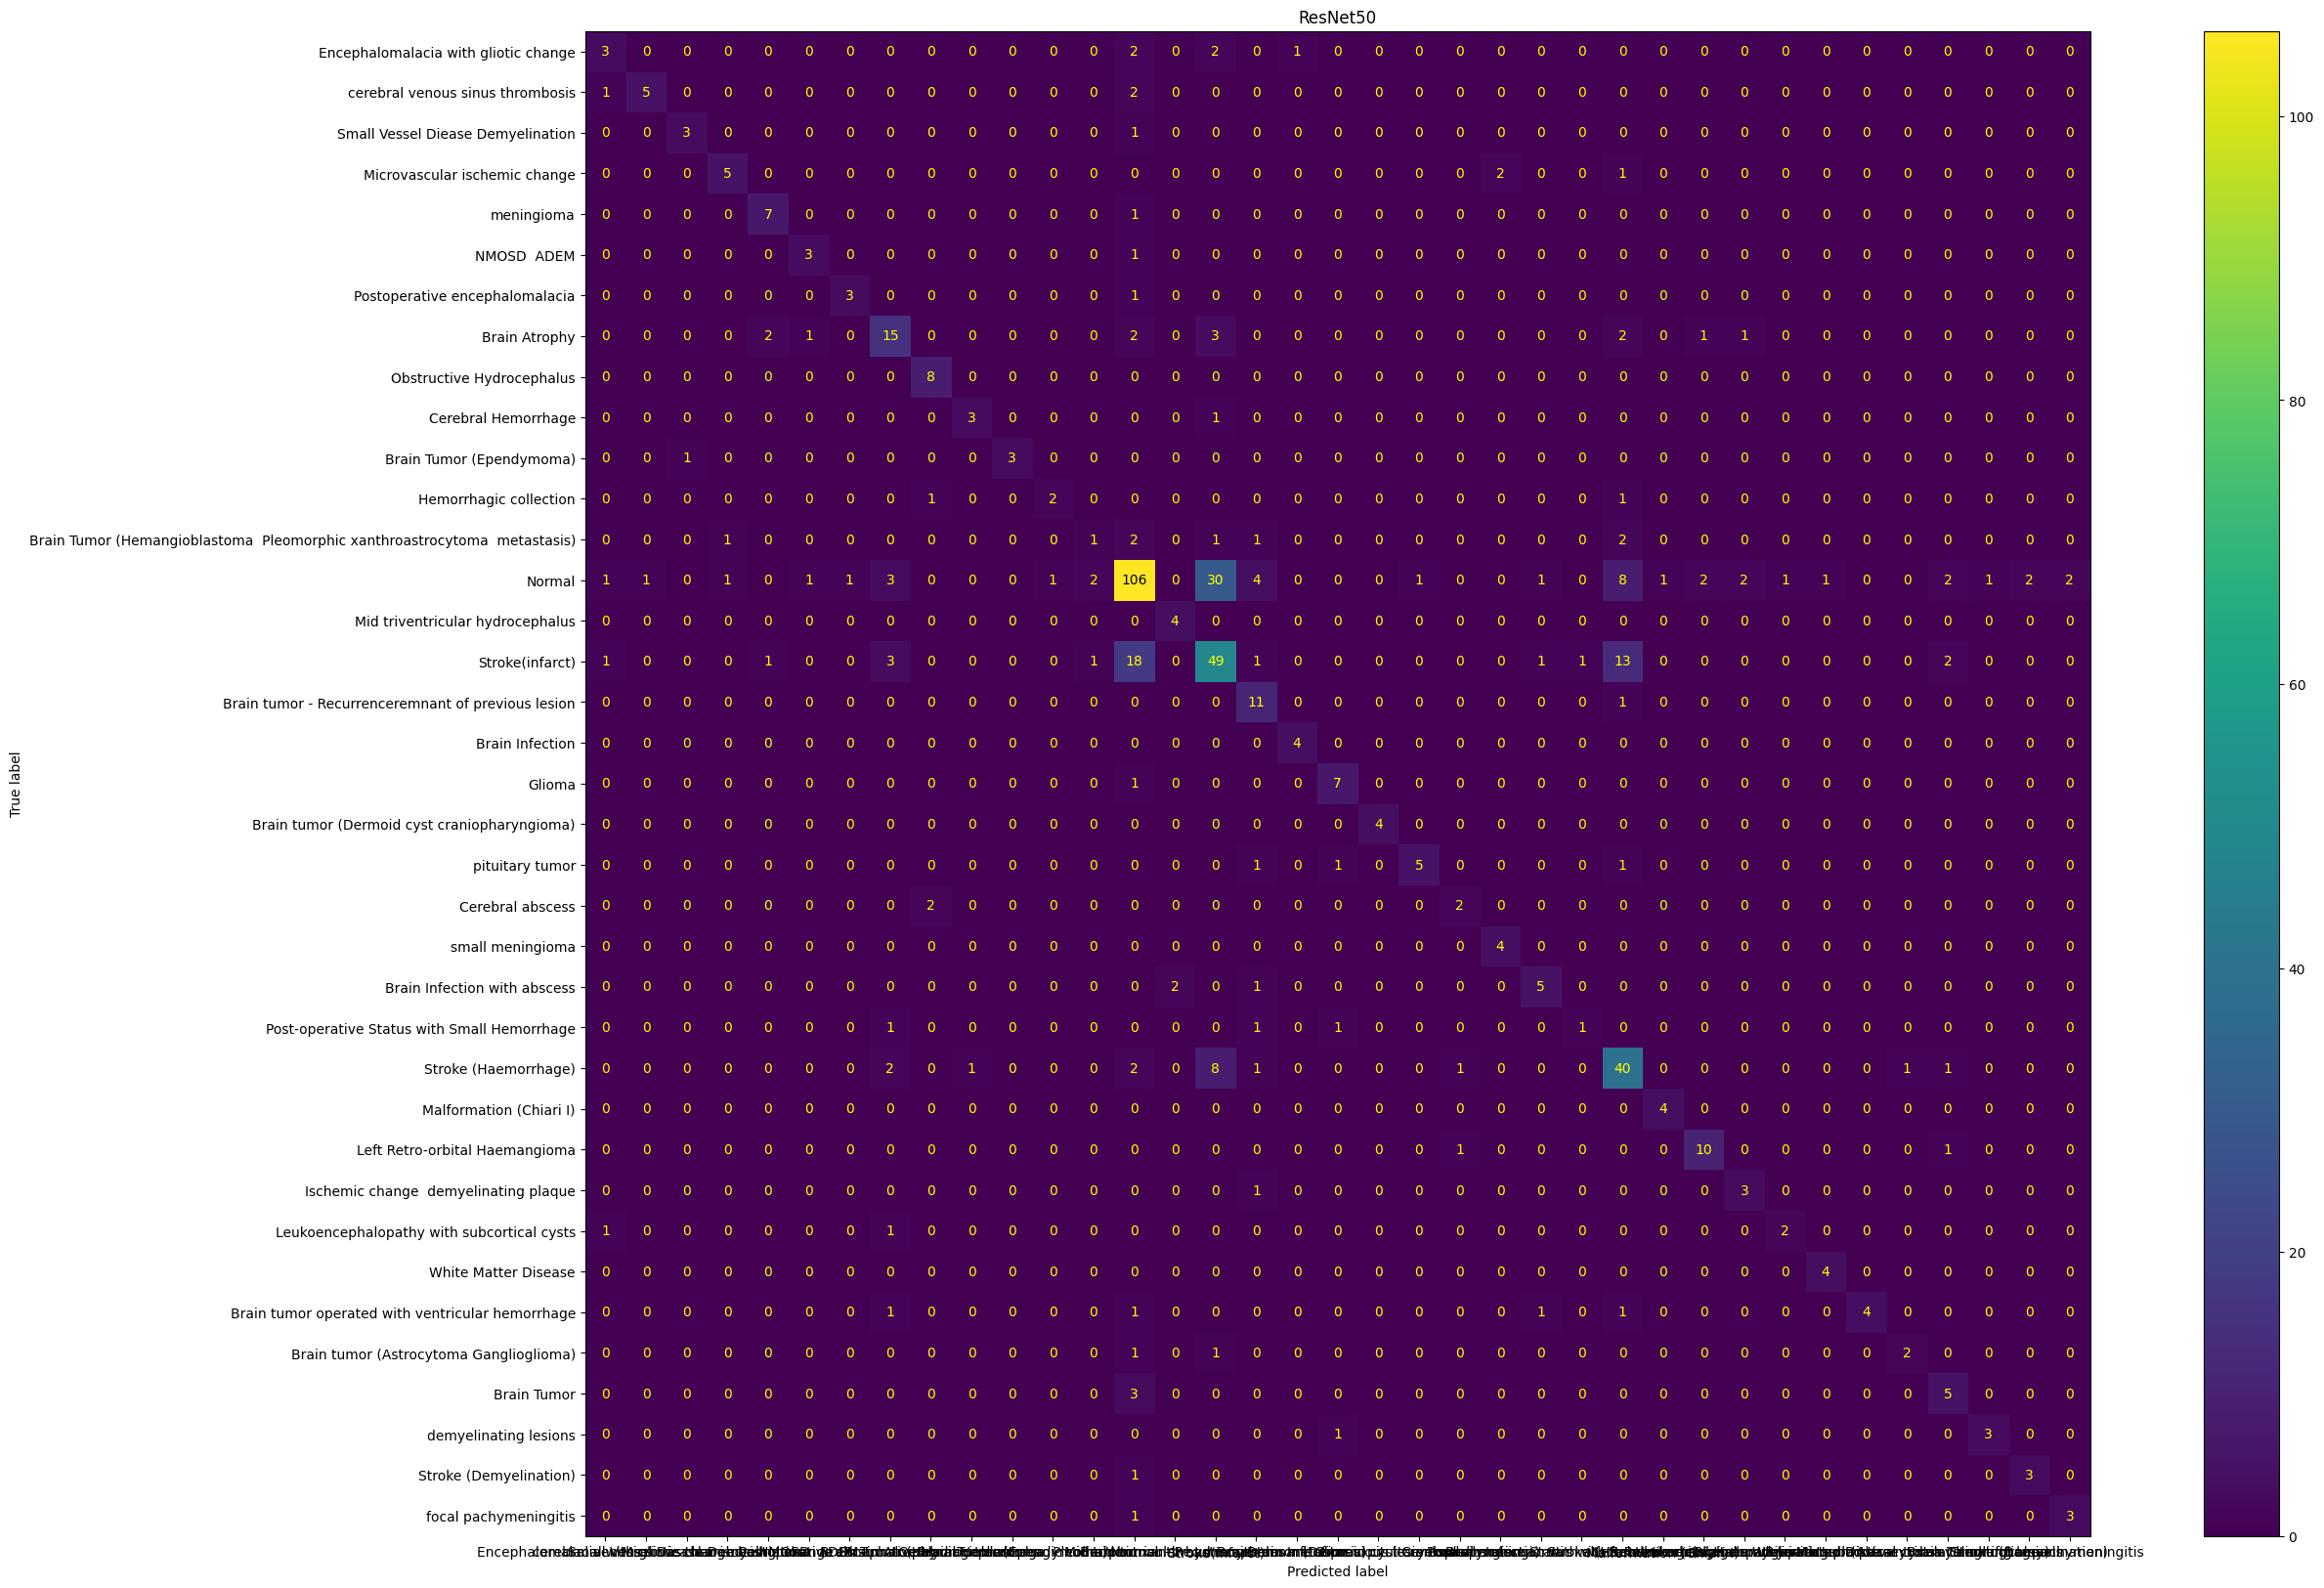

In [123]:
# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

# Set figure size
fig, ax = plt.subplots(figsize=(30, 20))

# Plot confusion matrix with color map
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
ax.figure.colorbar(im, ax=ax)

# Add title and axis labels
ax.set(title='ResNet50',
       xlabel='Predicted label',
       ylabel='True label')

# Add tick marks and labels for axes
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)

# Add values to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "yellow")

# Display plot
plt.show()

In [124]:
model = vgg_ft

model.eval() # Set the model to evaluation mode

predictions = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        labels.extend(label)
        label = label.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())

labels = [int(tensor.numpy()) for tensor in labels]

In [125]:
num_correct = 0
for i in range(len(labels)):
    if predictions[i] == labels[i]:
        num_correct += 1

accuracy = (num_correct / len(labels)) * 100
print(f'VGG16 Accuracy: {accuracy}')

VGG16 Accuracy: 53.13653136531366


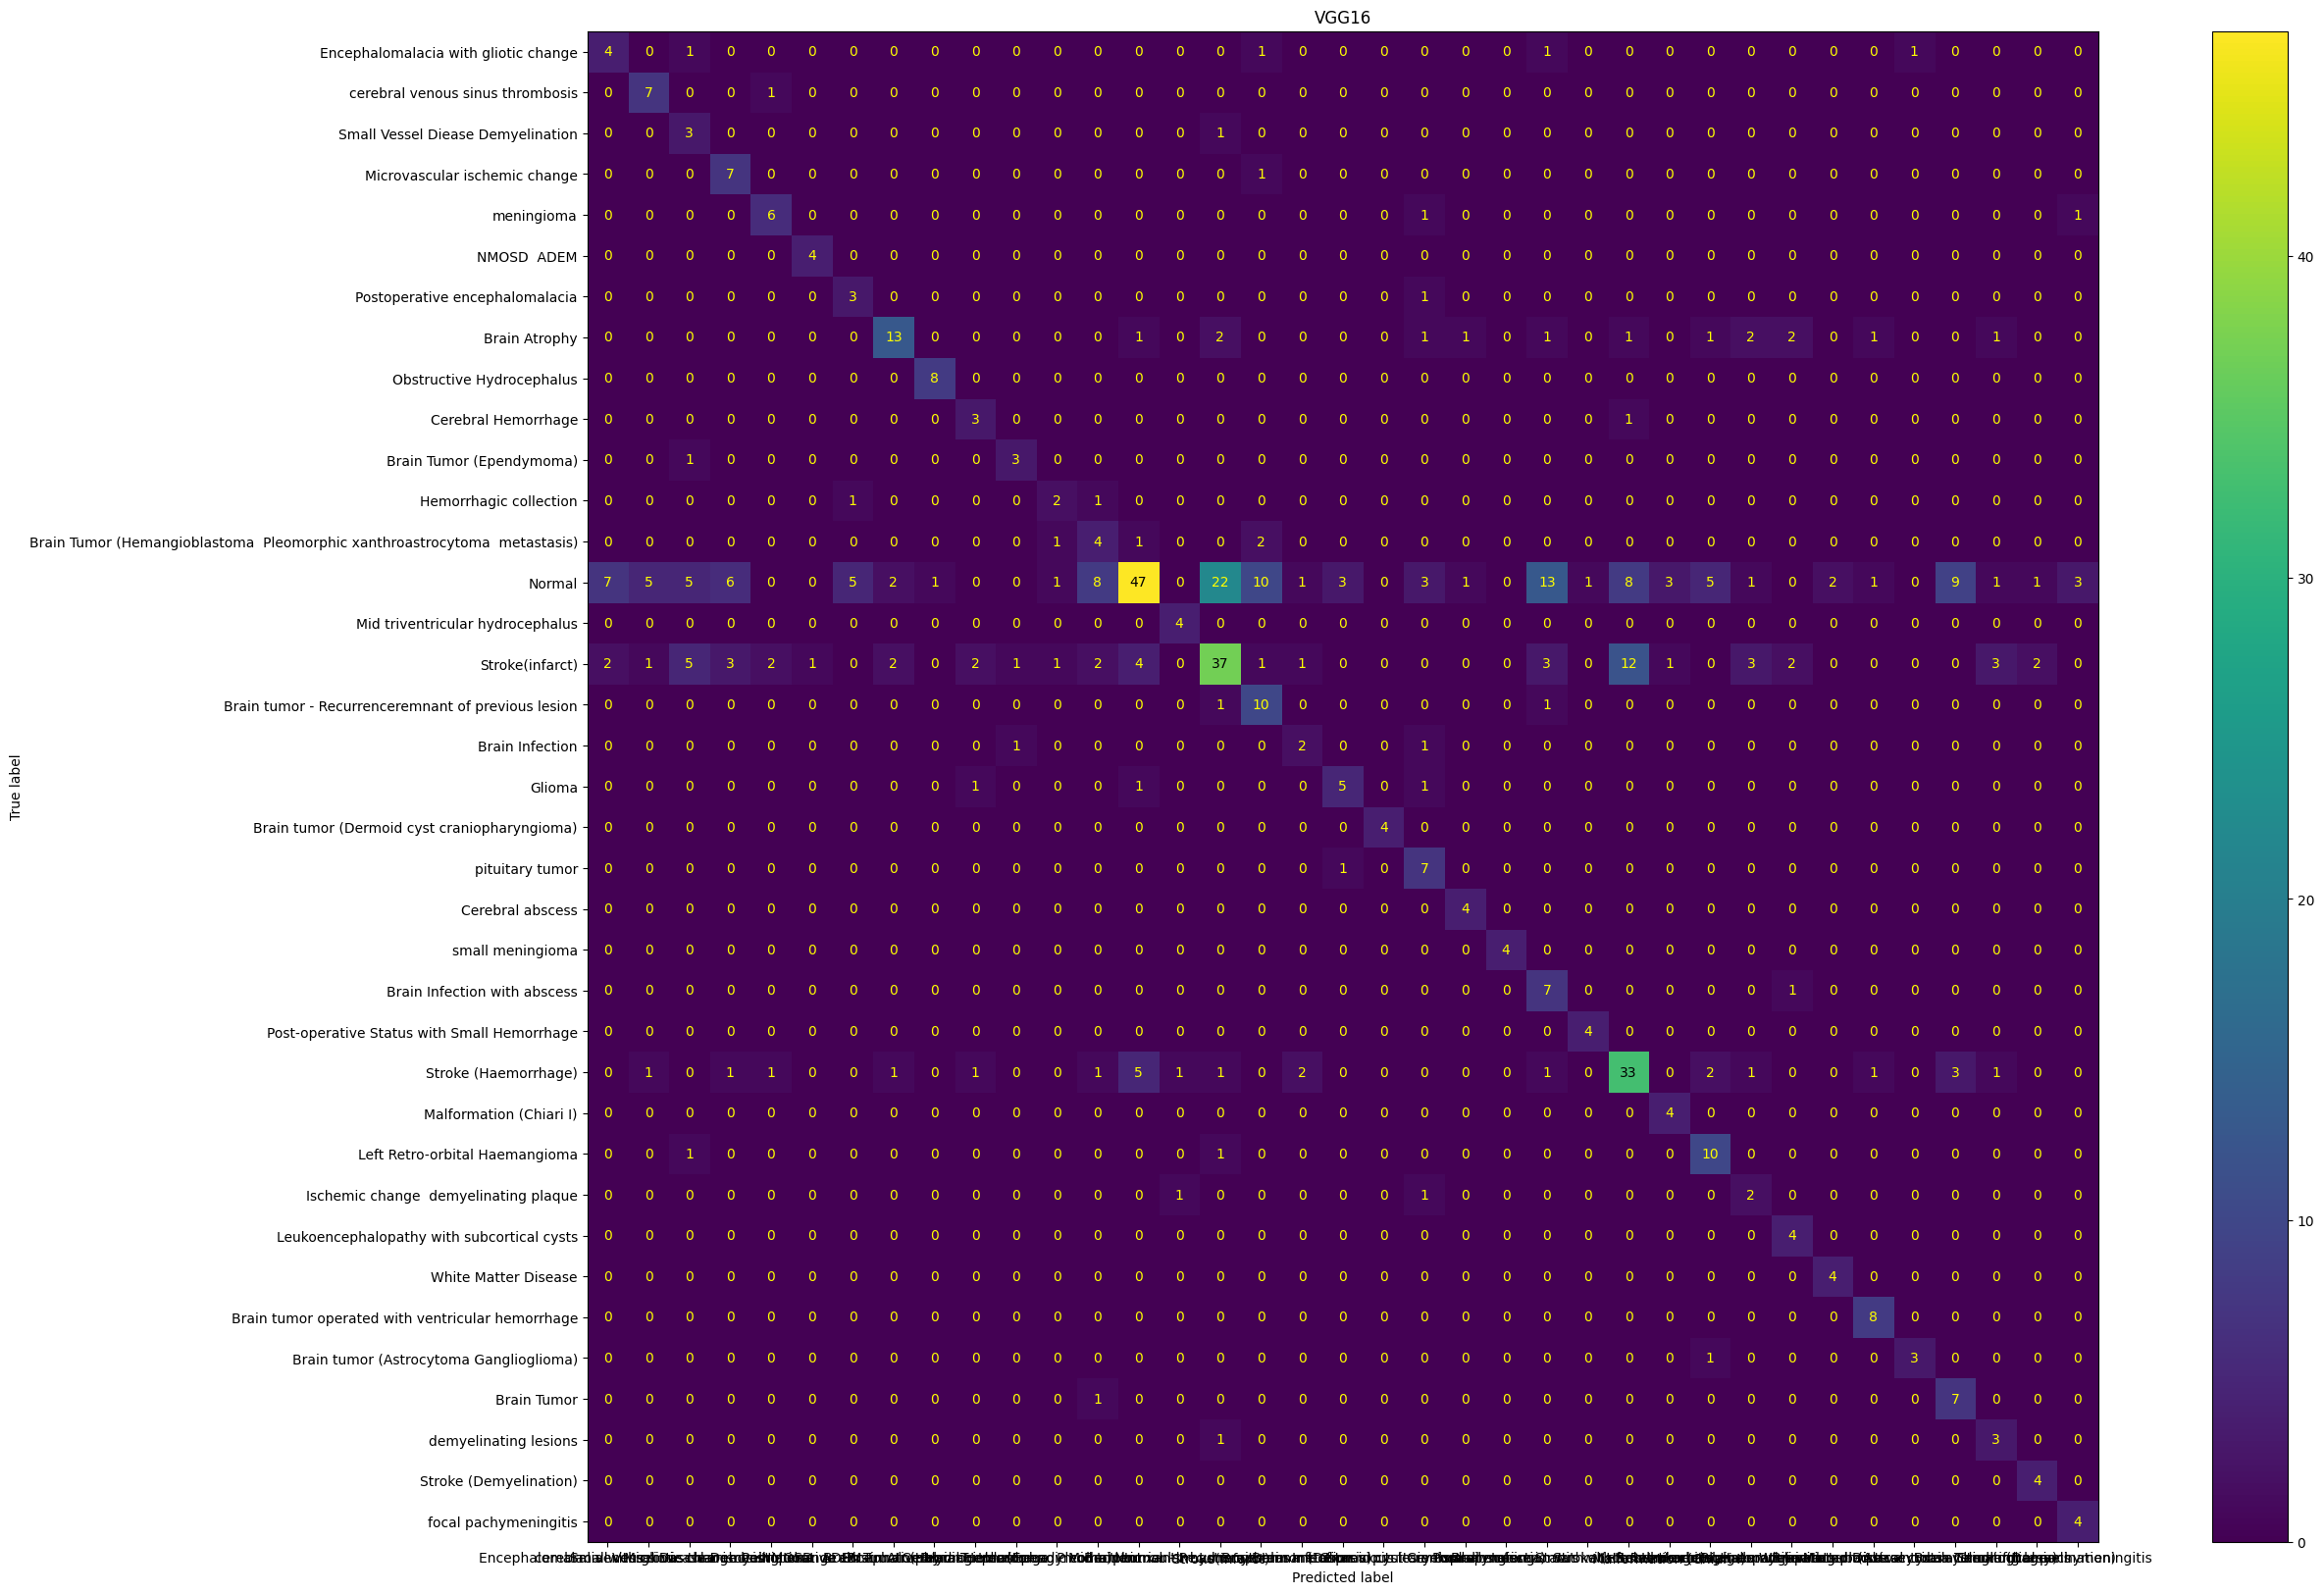

In [126]:
# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

# Set figure size
fig, ax = plt.subplots(figsize=(30, 20))

# Plot confusion matrix with color map
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
ax.figure.colorbar(im, ax=ax)

# Add title and axis labels
ax.set(title='VGG16',
       xlabel='Predicted label',
       ylabel='True label')

# Add tick marks and labels for axes
tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)

# Add values to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "yellow")

# Display plot
plt.show()